# MULTI-ARM BANDITS

In [1]:
# Import modules
from abc import ABC, abstractmethod
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Abstract bandit

In [2]:
class Bandit(ABC):

    def __init__(self, means, sigmas, init_est, arms=10, iters=10000, deterministic=False, stationary=True):
        """Initializes the abstarct bandit object and model attributes."""
        # Model variables initialization.
        self.means = means
        self.sigmas = sigmas
        self.est_means = np.full(arms, init_est)
        self.arms = arms
        self.Ns = np.zeros(arms)
        self.iters = iters
        self.deterministic = deterministic
        self.stationary = stationary
               
        # Simulation data initialization.
        self.avg_rewards = np.zeros(iters + 1)
        self.Qs = np.zeros((iters + 1, arms))
        self.Qs[0, :] = self.est_means
        self.qs = np.zeros((iters + 1, arms))
        self.qs[0, :] = self.means
        self.opt_actions = 0
    
    @abstractmethod
    def choose_action(self):
        pass
        
    def pull_arm(self, arm):
        """Draws a reward using a normal distribution you can set."""
        if self.deterministic == True:
            return self.means[arm]
        else:
            return np.random.normal(self.means[arm], self.sigmas[arm])
        
    @abstractmethod
    def update_model(self, arm, reward, iteration):
        pass        
        
    def update_sim_data(self, arm , reward, iteration):
        """Updates simulation data after an episode"""
        self.avg_rewards[iteration + 1] = self.avg_rewards[iteration] + (1. / (iteration + 1)) * (reward - self.avg_rewards[iteration]) 
        self.Qs[iteration + 1, :] = self.Qs[iteration, :]
        self.Qs[iteration + 1, arm] = self.est_means[arm]
        self.qs[iteration + 1, :] = self.means
            
    def run(self):
        """Runs a set of episodes."""
        for i in range(self.iters):
            arm = self.choose_action()
            reward = self.pull_arm(arm)
            self.update_model(arm, reward, i)
            self.update_sim_data(arm, reward, i)
                
    def get_avg_rewards(self):
        """Return the trend of the avarage reward"""
        return self.avg_rewards
    
    def get_real_means(self):
        return self.qs
    
    def get_est_means(self):
        return self.Qs
    
    def get_actions(self):
        return self.Ns
    
    def get_opt_actions(self):
        return self.opt_actions / self.iters

In [3]:
class EpsBandit(Bandit):
    
    def __init__(self, means, sigmas, init_est, arms=10, iters=10000, eps=0., alpha=0., deterministic=False, stationary=True):
        super().__init__(means, sigmas, init_est, deterministic=deterministic, stationary=stationary)
        self.eps = eps
        self.alpha = alpha
        
    def choose_action(self):
        """
        Implements the epsilon-greedy policy: exploits knowledge or explores new possibilities.
        """
        choice = np.random.choice([0, 1], p=[1-self.eps, self.eps])
        if choice == 0:
            # Greedy choice.
            self.opt_actions += 1
            return np.argmax(self.est_means)
        else:
            # Explorative choice.
            return np.random.choice(list(range(0, self.arms)))
        
    def update_model(self, arm, reward, iteration):
        """Updates estimates and other data after an episode."""
        # Update choice count.
        self.Ns[arm] += 1
        # Update step size
        if self.alpha == 0:
            step_size = 1. / self.Ns[arm]
        else:
            step_size = self.alpha
        # Update reward estimate
        self.est_means[arm] = self.est_means[arm] + step_size * (reward - self.est_means[arm])
        # Decrease exploration probability.
        if (self.stationary == True) and (self.eps >= ((self.eps / self.iters) * (iteration + 1))):
            self.eps -= (self.eps / self.iters) * (iteration + 1)

'\n# Estimates plots.\nfig, ax = plt.subplots(arms, figsize=(20, 50))\nfig.suptitle(\'Action values estimates\')\nfor i in range(arms):\n    ax[i].plot(qs_0[:, i], label="Real")\n    ax[i].plot(Qs_0[:, i], label="$\\epsilon=0$")\n    ax[i].plot(Qs_01[:, i], label="$\\epsilon=0.1$")\n    ax[i].plot(Qs_03[:, i], label="$\\epsilon=0.3$")\n    ax[i].legend(loc=\'upper right\')\n    ax[i].set(xlabel=\'Iterations\', ylabel=\'Action value\')\n    ax[i].set_title("Arm " + str(i + 1))\n\n# Frequency plots.\nbins = np.linspace(0, arms - 1, arms)\nplt.figure(figsize=(12, 12))\nplt.bar(bins, N_0, width=0.33, color=\'r\', label=\'$\\epsilon=0$\')\nplt.bar(bins + 0.33, N_01, width=0.33, color=\'g\', label=\'$\\epsilon=0.01$\')\nplt.bar(bins + 0.66, N_03, width=0.33, color=\'b\', label=\'$\\epsilon=0.03$\')\nplt.legend()\nplt.xlabel("Iterations")\nplt.ylabel("Number of actions taken")\nplt.title("Actions Frequencies")\nplt.show()'

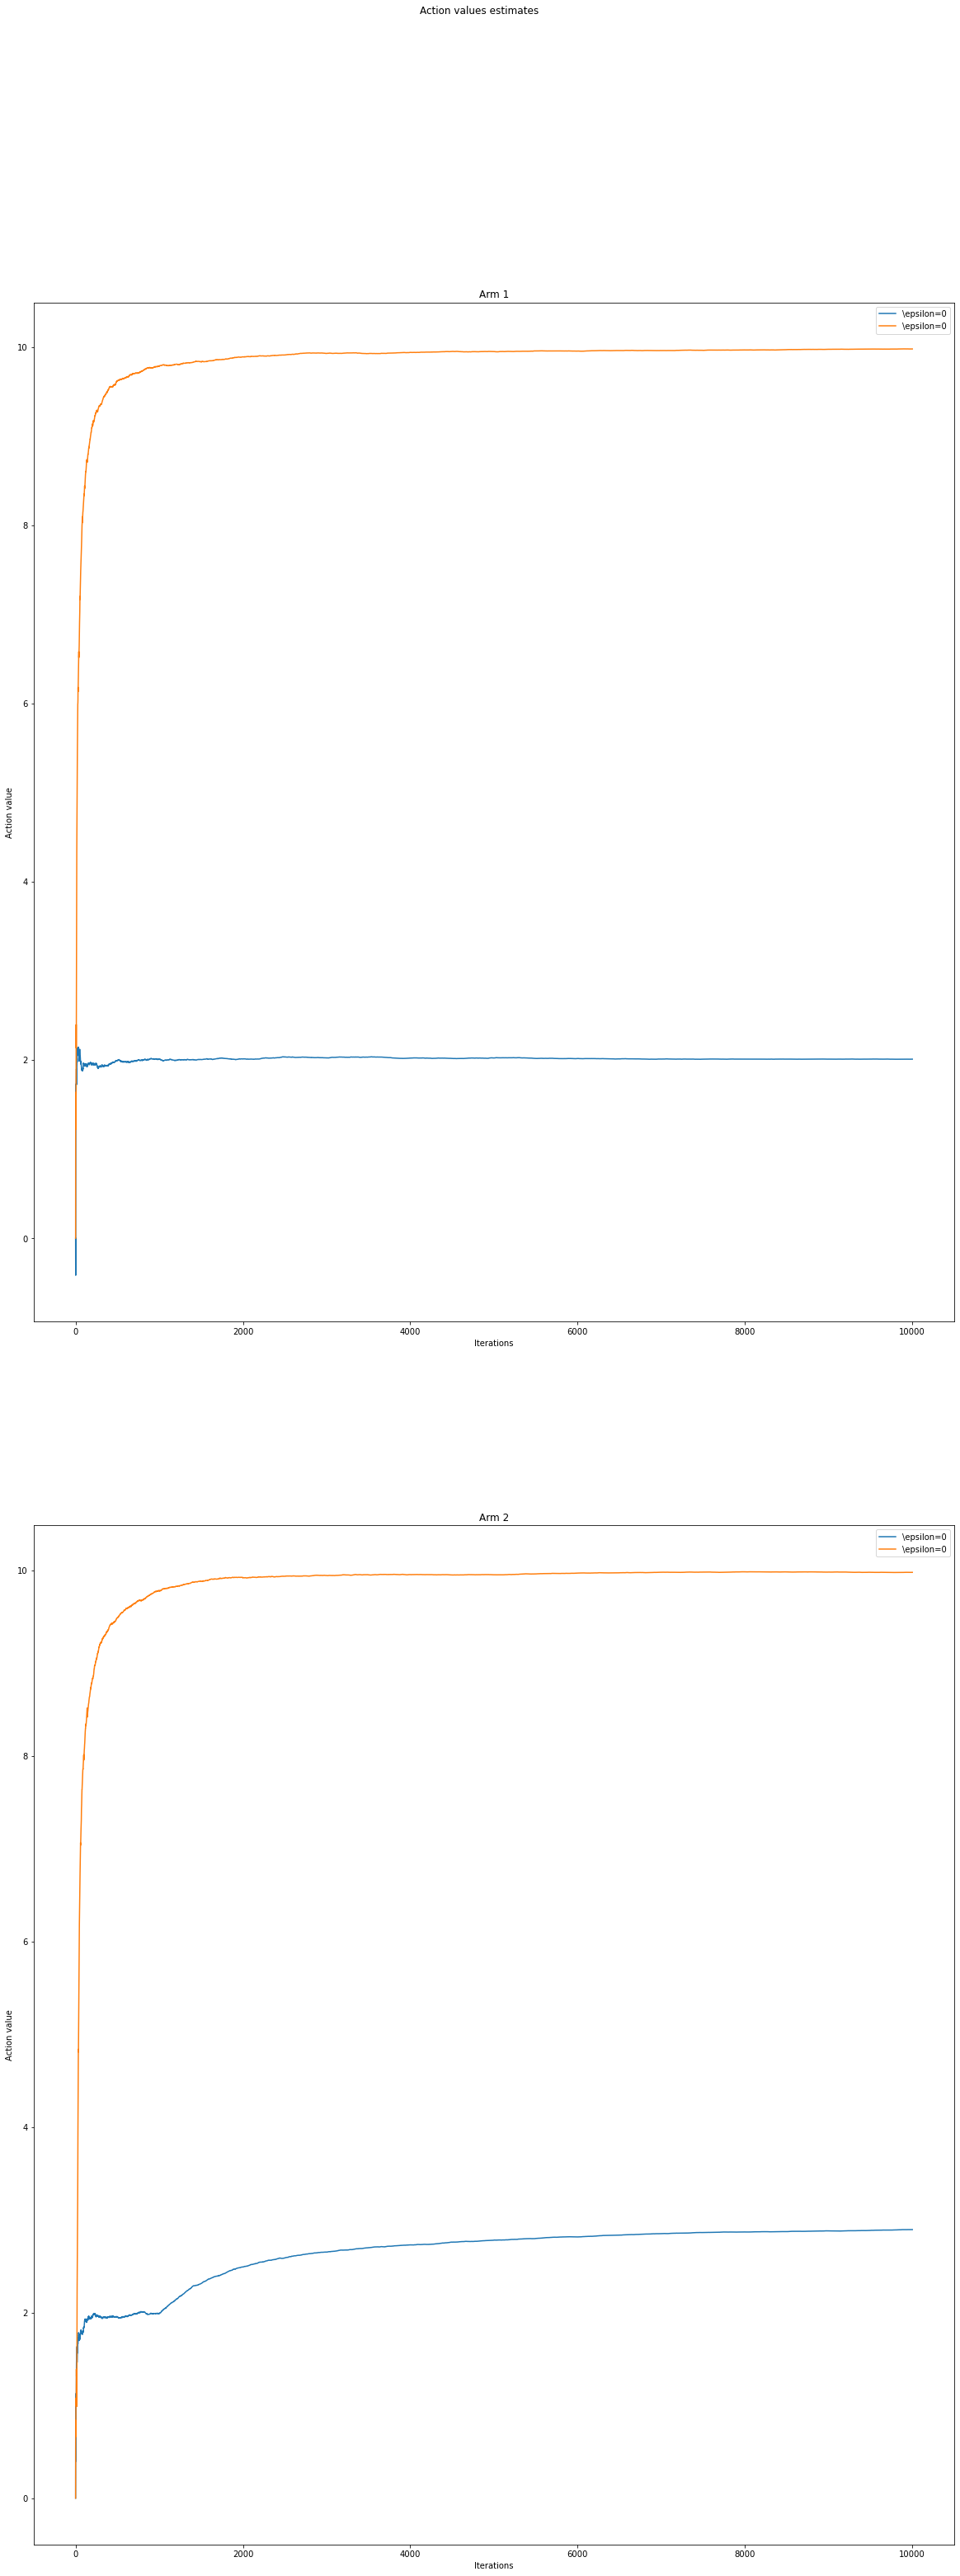

In [20]:
# Simulation parameters.
iters = 10000
opt_init = 0.
arms = 10
means = list(range(1, arms + 1))
sigmas = np.full(arms, 1)
alphas = [0., 0.5]
epsilons = [0., 0.1, 0.2]

# Simulation 
rews = np.zeros((len(alphas), len(epsilons), iters + 1))

# Bandits execution.
for i in range(len(alphas)):
    for j in range(len(epsilons)):
        bandit = EpsBandit(means, sigmas, opt_init, alpha=alphas[i], eps=epsilons[j], deterministic=False)
        bandit.run()
        rews[i, j, :] = bandit.get_avg_rewards()

fig, ax = plt.subplots(len(alphas), figsize=(20, 50))
fig.suptitle('Action values estimates')
for i in range(len(alphas)):
    for j in range(len(alphas)):
        ax[i].plot(rews[i, j, :], label="\epsilon=0")
    ax[i].legend(loc='upper right')
    ax[i].set(xlabel='Iterations', ylabel='Action value')
    ax[i].set_title("Arm " + str(i + 1))

"""
# Estimates plots.
fig, ax = plt.subplots(arms, figsize=(20, 50))
fig.suptitle('Action values estimates')
for i in range(arms):
    ax[i].plot(qs_0[:, i], label="Real")
    ax[i].plot(Qs_0[:, i], label="$\epsilon=0$")
    ax[i].plot(Qs_01[:, i], label="$\epsilon=0.1$")
    ax[i].plot(Qs_03[:, i], label="$\epsilon=0.3$")
    ax[i].legend(loc='upper right')
    ax[i].set(xlabel='Iterations', ylabel='Action value')
    ax[i].set_title("Arm " + str(i + 1))

# Frequency plots.
bins = np.linspace(0, arms - 1, arms)
plt.figure(figsize=(12, 12))
plt.bar(bins, N_0, width=0.33, color='r', label='$\epsilon=0$')
plt.bar(bins + 0.33, N_01, width=0.33, color='g', label='$\epsilon=0.01$')
plt.bar(bins + 0.66, N_03, width=0.33, color='b', label='$\epsilon=0.03$')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Number of actions taken")
plt.title("Actions Frequencies")
plt.show()"""